# **Advanced Tree Models – Bagging Tree**

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.


1. [Bagging](#1-bagging)  
   1.1 [Bagging for Regression Trees](#11-bagging-for-regression-trees)  
   1.2 [Out-of-Bag (OOB) Prediction](#12-out-of-bag-oob-prediction)  




#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/15xldGmwRRCZy7s2BfI50CGkHYr6zMLU9?usp=sharing)*

#### *Useful information about [Advanced Tree Models – Bagging Tree in R](https://yanyudm.github.io/Data-Mining-R/lecture/7.A_Bagging.html)*



## Lab Overview

In this lab, we will cover state-of-the-art techniques within the tree-modeling framework. We will use the same datasets as in the previous lab:

- **Boston Housing** dataset  
- **Taiwan Credit Card Default** dataset (subsampled to **n = 12,000** observations)


In [1]:
# ============================================================
# Bagging Lab (Google Colab) — Boston Housing + Credit Default
#   1.1 Bagging for Regression Trees (Boston) + Test MSE
#   1.2 Out-of-Bag (OOB) Prediction (Boston)
#   (Optional) Compare with a single tree
#   (Optional) How many trees are good? (n_estimators vs Test MSE)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 123


In [2]:
# ============================================================
# 0. Load Boston Housing data (CMU StatLib format) — as requested
# ============================================================
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

data = np.hstack([
    raw_df.values[::2, :],      # even rows: 13 columns
    raw_df.values[1::2, :2]     # odd rows: first 2 columns
])
target = raw_df.values[1::2, 2] # odd rows: 3rd column is MEDV

feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

boston = pd.DataFrame(data, columns=feature_names)
boston["MEDV"] = target

boston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# ============================================================
# 2. Load Credit Card Default data (60/40 split)
#    (Loaded for consistency with your lab context; bagging demo below is Boston.)
# ============================================================
credit_url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(credit_url)

# Convert categorical variables (similar to as.factor in R)
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")

credit_train, credit_test = train_test_split(
    credit_data, test_size=0.40, random_state=RANDOM_STATE
)

print("Credit train:", credit_train.shape, " Credit test:", credit_test.shape)
credit_train.head()


Credit train: (7200, 24)  Credit test: (4800, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
11983,240000,2,2,1,36,0,0,0,0,0,...,215858,210887,205828,8193,9000,6600,6400,6382,5994,0
11033,430000,2,2,2,50,0,0,0,0,0,...,207496,250337,255277,10000,8000,12000,50000,28000,60000,0
5667,50000,2,3,2,32,0,0,0,0,0,...,37657,38530,39409,1755,1614,1627,1500,1500,1822,0
8089,60000,2,2,2,25,0,0,0,0,0,...,9287,10076,10612,1276,1144,1161,950,700,1000,0
3989,30000,1,3,2,39,1,2,0,0,0,...,24865,24528,25011,0,2000,1100,1100,1042,917,1


## 1 Bagging (Bootstrap Aggregating)

**Bagging** stands for **Bootstrap Aggregating**. It uses the bootstrap idea, but the goal is **not** to study bias or the standard errors of estimates. Instead, bagging aims to **improve prediction accuracy**.

The key idea is:

1. Draw many **bootstrap samples** from the training data (sampling with replacement).  
2. Fit a **separate tree** on each bootstrap sample.  
3. **Aggregate** predictions from all trees (e.g., average predictions for regression).

For more details, see  
- <a href="https://en.wikipedia.org/wiki/Bootstrap_aggregating">Wikipedia</a>  
- the original paper: <a href="https://link.springer.com/content/pdf/10.1007/BF00058655.pdf">Leo Breiman (1996)</a>  

In **scikit-learn**, bagging is available as an ensemble method in the `sklearn.ensemble` module.


In [4]:
# ============================================================
# 1. Train/Test split (60/40) — Boston
# ============================================================
X_boston = boston.drop(columns=["MEDV"])
y_boston = boston["MEDV"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_boston, y_boston, test_size=0.40, random_state=RANDOM_STATE
)

print("Boston train:", X_train_b.shape, " Boston test:", X_test_b.shape)


Boston train: (303, 13)  Boston test: (203, 13)


## 1.1 [Bagging for Regression Trees](#11-bagging-for-regression-trees)  


In [5]:
# ============================================================
# 1.1 Bagging for Regression Trees (Boston)
#   Fit bagging on Boston training data, calculate test MSE
# ============================================================
boston_bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    n_estimators=100,
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

boston_bag.fit(X_train_b, y_train_b)
boston_bag_pred = boston_bag.predict(X_test_b)

mse_bag = mean_squared_error(y_test_b, boston_bag_pred)
print(f"Bagging (100 trees) Test MSE: {mse_bag:.5f}")


Bagging (100 trees) Test MSE: 15.83039


In [6]:
# ============================================================
# Compare with a single regression tree
# ============================================================
boston_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
boston_tree.fit(X_train_b, y_train_b)

boston_tree_pred = boston_tree.predict(X_test_b)
mse_tree = mean_squared_error(y_test_b, boston_tree_pred)

print(f"Single Tree Test MSE: {mse_tree:.5f}")


Single Tree Test MSE: 34.35532


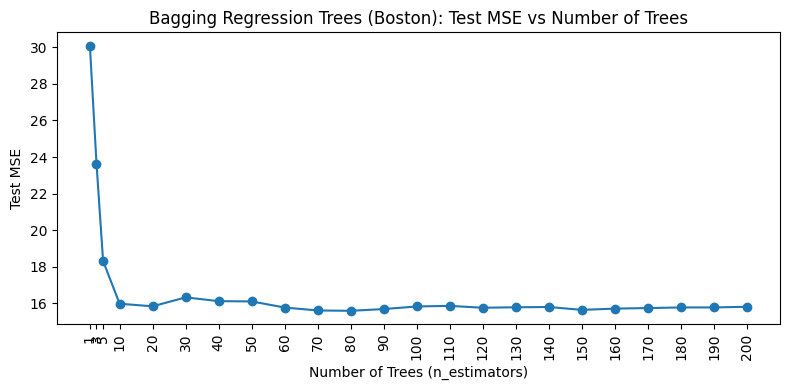

/tmp/ipython-input-2396696381.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_dist, labels=ntree, showfliers=False)


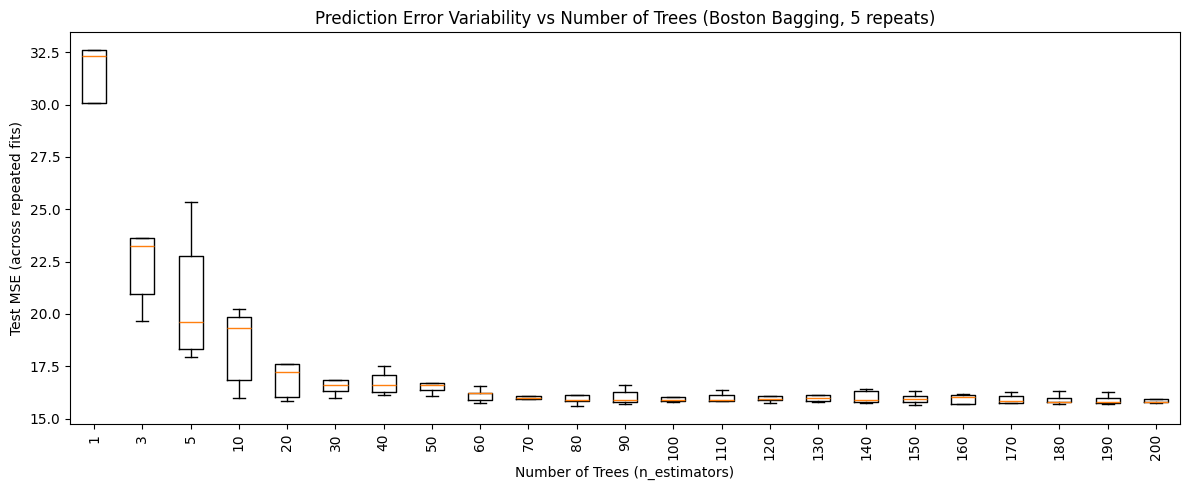

Best n_estimators by median test MSE: 180


In [7]:
# ============================================================
# How many trees are good?
#   (A) Average test MSE vs n_estimators (single fit per n)
#   (B) Boxplot of test MSE across repeated fits (variance vs n)
# ============================================================

# Same grid as before
ntree = [1, 3, 5] + list(range(10, 201, 10))

# ------------------------------------------------------------
# (A) Single fit per n: line plot (baseline)
# ------------------------------------------------------------
mse_test = []

for n in ntree:
    model_n = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
        n_estimators=n,
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model_n.fit(X_train_b, y_train_b)
    pred_n = model_n.predict(X_test_b)
    mse_test.append(mean_squared_error(y_test_b, pred_n))

plt.figure(figsize=(8, 4))
plt.plot(ntree, mse_test, marker="o")
plt.xticks(ntree, rotation=90)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Test MSE")
plt.title("Bagging Regression Trees (Boston): Test MSE vs Number of Trees")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# (B) Repeated fits per n: boxplot of test MSE
#     This shows variability due to bootstrap sampling randomness.
# ------------------------------------------------------------
n_repeats = 5  # increase to 100 for smoother boxplots (slower)

mse_dist = []  # list of lists; mse_dist[i] contains MSEs for ntree[i]

for n in ntree:
    mses_n = []
    for r in range(n_repeats):
        # Vary the random_state across repeats to change bootstrap draws
        model_nr = BaggingRegressor(
            estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
            n_estimators=n,
            bootstrap=True,
            random_state=RANDOM_STATE + r,
            n_jobs=-1
        )
        model_nr.fit(X_train_b, y_train_b)
        pred_nr = model_nr.predict(X_test_b)
        mses_n.append(mean_squared_error(y_test_b, pred_nr))
    mse_dist.append(mses_n)

plt.figure(figsize=(12, 5))
plt.boxplot(mse_dist, labels=ntree, showfliers=False)
plt.xticks(rotation=90)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Test MSE (across repeated fits)")
plt.title(f"Prediction Error Variability vs Number of Trees (Boston Bagging, {n_repeats} repeats)")
plt.tight_layout()
plt.show()

# Optional: quick numeric summary (median MSE per n)
median_mse = [np.median(mses) for mses in mse_dist]
best_n = ntree[int(np.argmin(median_mse))]
print(f"Best n_estimators by median test MSE: {best_n}")


/tmp/ipython-input-2050921852.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_dist, labels=ntree, showfliers=False)


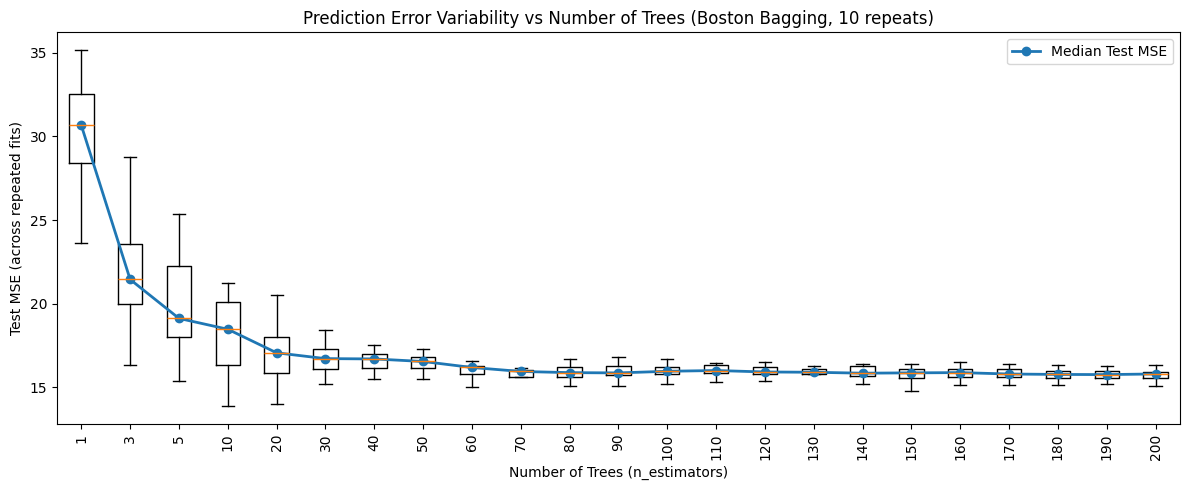

Best n_estimators by median test MSE: 190


In [8]:
# ============================================================
# (C) Repeated fits per n: boxplot + line/curve summary
#   - Boxplot shows distribution of test MSE across repeats
#   - Line/curve overlays a summary statistic (median by default)
# ============================================================

ntree = [1, 3, 5] + list(range(10, 201, 10))
n_repeats = 10  # increase to 100 if you want smoother distributions (slower)

mse_dist = []  # list of lists

for n in ntree:
    mses_n = []
    for r in range(n_repeats):
        model_nr = BaggingRegressor(
            estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
            n_estimators=n,
            bootstrap=True,
            random_state=RANDOM_STATE + r,  # vary bootstrap randomness across repeats
            n_jobs=-1
        )
        model_nr.fit(X_train_b, y_train_b)
        pred_nr = model_nr.predict(X_test_b)
        mses_n.append(mean_squared_error(y_test_b, pred_nr))
    mse_dist.append(mses_n)

# Boxplot
plt.figure(figsize=(12, 5))
plt.boxplot(mse_dist, labels=ntree, showfliers=False)
plt.xticks(rotation=90)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Test MSE (across repeated fits)")
plt.title(f"Prediction Error Variability vs Number of Trees (Boston Bagging, {n_repeats} repeats)")

# ------------------------------------------------------------
# Overlay a line/curve: median (or mean) MSE across repeats
# ------------------------------------------------------------
xpos = np.arange(1, len(ntree) + 1)  # boxplot positions are 1..K

median_mse = np.array([np.median(mses) for mses in mse_dist])
# Alternative: mean_mse = np.array([np.mean(mses) for mses in mse_dist])

plt.plot(xpos, median_mse, marker="o", linewidth=2, label="Median Test MSE")

plt.legend()
plt.tight_layout()
plt.show()

best_n = ntree[int(np.argmin(median_mse))]
print(f"Best n_estimators by median test MSE: {best_n}")


## 1.2 [Out-of-Bag (OOB) Prediction](#12-out-of-bag-oob-prediction)

Out-of-bag (OOB) prediction is conceptually similar to **LOOCV**. We fit the model using the **full training sample**. In each bootstrap replication, the observations **not selected** in the bootstrap sample (the “out-of-bag” data) serve as a **test set**, and we compute the prediction error on those held-out observations.

By aggregating these errors across bootstrap replications, we obtain the **OOB error** (often reported as **RMSE** by default in many implementations).


In [9]:
# ============================================================
# 1.2 Out-of-Bag (OOB) Prediction (Boston)
# Notes:
# - Set oob_score=True to enable OOB predictions.
# - bag_oob.oob_score_ is R^2 (sklearn convention for regression).
# - We'll compute OOB MSE/RMSE from oob_prediction_ for comparability.
# ============================================================
boston_bag_oob = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    n_estimators=100,
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

boston_bag_oob.fit(X_train_b, y_train_b)

oob_pred = boston_bag_oob.oob_prediction_
mask = ~np.isnan(oob_pred)  # just in case any sample is never OOB (rare but possible)

oob_mse = mean_squared_error(y_train_b[mask], oob_pred[mask])
oob_rmse = np.sqrt(oob_mse)

print(f"OOB R^2 (sklearn): {boston_bag_oob.oob_score_:.5f}")
print(f"OOB MSE: {oob_mse:.5f}")
print(f"OOB RMSE: {oob_rmse:.5f}")


OOB R^2 (sklearn): 0.85336
OOB MSE: 12.29344
OOB RMSE: 3.50620


In [10]:
%%shell
jupyter nbconvert --to html ///content/7_A_Bagging_trees.ipynb

[NbConvertApp] Converting notebook ///content/7_A_Bagging_trees.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 495305 bytes to /content/7_A_Bagging_trees.html
